## DVC pipeline

Homework (block 6, part 1) MLOPs3 course

### References

Based on previous homeworks:

 - [EDA (NY-Tree-2015)](eda.html)
 - [Snakemake](snakemake.html)

Sources:

 - DVC pipeline scripts and config in repository: https://gitlab.com/ptaiga-edu/mlops3.
 - [“NY 2015 Street Tree Census - Tree Data”](https://www.kaggle.com/datasets/new-york-city/ny-2015-street-tree-census-tree-data)

It's enough to download source data to fully reproduce results of pipeline:
```
$ kaggle datasets download -d new-york-city/ny-2015-street-tree-census-tree-data
```


### Description

DVC pipeline is updated copy of Snakemake one. There are two versions of pipeline for:

 - Logistir Regression
 - Random Forest

Google Drive is used for remote storage to save tracked data, models and metrics.

Environment variables should be set:

 - __GDRIVE_FOLDER_ID__
 - GDRIVE_CREDENTIALS_DATA (optinal: Google.Drive folder is public, but Google might require authorization via any google accounts)

Configuration:

In [21]:
import joblib
import json

import pandas as pd
from dvc.api import DVCFileSystem

import warnings

warnings.filterwarnings('ignore')

repo_url = 'https://gitlab.com/ptaiga-edu/mlops3.git'
gdrive_folder_id = %env GDRIVE_FOLDER_ID
gdrive_url = 'gdrive://' + gdrive_folder_id
dvc_config = {
    'core': {'remote': 'gdrive'},
    'remote': {'gdrive': {'url': gdrive_url}},
}

logit_commit = "9ac5fbf"
forest_commit = "9401e0a"

summary_json = '/dvc/reports/summary.json'
conf_matrix_png = '/dvc/reports/conf_matrix.png'

### Load data

What is tracked by DVC:

In [22]:
fs_logit = DVCFileSystem(repo_url, rev=logit_commit, config=dvc_config)
fs_forest = DVCFileSystem(repo_url, rev=forest_commit, config=dvc_config)

fs_forest.find("/", detail=False, dvc_only=True)

['/dvc/data_prepared/alive_trees_base.csv',
 '/dvc/data_prepared/test.csv',
 '/dvc/data_prepared/train.csv',
 '/dvc/data_processed/X_test.npz',
 '/dvc/data_processed/X_train.npz',
 '/dvc/data_processed/y_test.npy',
 '/dvc/data_processed/y_train.npy',
 '/dvc/models/label_enc.pkl',
 '/dvc/models/model.pkl',
 '/dvc/models/oh_enc.pkl',
 '/dvc/ny-2015-street-tree-census-tree-data.zip',
 '/dvc/reports/conf_matrix.png',
 '/dvc/reports/summary.json']

Load summary of every pipeline:

In [23]:
summary_logit = fs_logit.read_text(summary_json)
summary_forest = fs_forest.read_text(summary_json)
print("Summary (Logistic Regression):", summary_logit)
print("Summary (Random Forest):", summary_forest)

Summary (Logistic Regression): {"0": {"precision": 0.35153061224489796, "recall": 0.023798832510103278, "f1-score": 0.044579599495325285, "support": 28951.0}, "1": {"precision": 0.8154441071391694, "recall": 0.9955248810311682, "f1-score": 0.896530976565715, "support": 158655.0}, "2": {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 8046.0}, "accuracy": 0.8107967207081962, "macro avg": {"precision": 0.38899157312802246, "recall": 0.3397745711804238, "f1-score": 0.3137035253536801, "support": 195652.0}, "weighted avg": {"precision": 0.7132635882754429, "recall": 0.8107967207081962, "f1-score": 0.7335971320100111, "support": 195652.0}}
Summary (Random Forest): {"0": {"precision": 0.3587570621468927, "recall": 0.008773444786017754, "f1-score": 0.01712802184834283, "support": 28951.0}, "1": {"precision": 0.8135743908894222, "recall": 0.9978317733446787, "f1-score": 0.8963316932867552, "support": 158655.0}, "2": {"precision": 0.35294117647058826, "recall": 0.015659955257270694,

More convenient way to see summary is Pandas DataFrame:

 - Logistic Regression:

In [24]:
summary_logit_df = pd.read_json(fs_logit.read_text(summary_json))
summary_logit_df

0              1     2  accuracy      macro avg  \
precision      0.351531       0.815444     0  0.810797       0.388992   
recall         0.023799       0.995525     0  0.810797       0.339775   
f1-score       0.044580       0.896531     0  0.810797       0.313704   
support    28951.000000  158655.000000  8046  0.810797  195652.000000   

            weighted avg  
precision       0.713264  
recall          0.810797  
f1-score        0.733597  
support    195652.000000

 - Random Forest:

In [25]:
summary_forest_df = pd.read_json(fs_forest.read_text(summary_json))
summary_forest_df

0              1            2  accuracy      macro avg  \
precision      0.358757       0.813574     0.352941  0.811088       0.508424   
recall         0.008773       0.997832     0.015660  0.811088       0.340755   
f1-score       0.017128       0.896332     0.029989  0.811088       0.314483   
support    28951.000000  158655.000000  8046.000000  0.811088  195652.000000   

            weighted avg  
precision       0.727331  
recall          0.811088  
f1-score        0.730607  
support    195652.000000

### Compare metrics

In [26]:
logit_metrics = summary_logit_df.loc['f1-score'][['accuracy', 'weighted avg']]
logit_metrics.name = "Logistic Regression"
logit_metrics = logit_metrics.rename({'weighted avg': 'f1-weighted'})

forest_metrics = summary_forest_df.loc['f1-score'][
    ['accuracy', 'weighted avg']
]
forest_metrics.name = "Random Forest"
forest_metrics = forest_metrics.rename({'weighted avg': 'f1-weighted'})

pd.DataFrame([logit_metrics, forest_metrics]).T

Logistic Regression  Random Forest
accuracy                0.810797       0.811088
f1-weighted             0.733597       0.730607

### Confusion matrices

In [27]:
from IPython.display import Image

logit_conf_matrix = fs_logit.read_bytes(conf_matrix_png)
forest_conf_matrix = fs_forest.read_bytes(conf_matrix_png)

 - Logistic Regression:

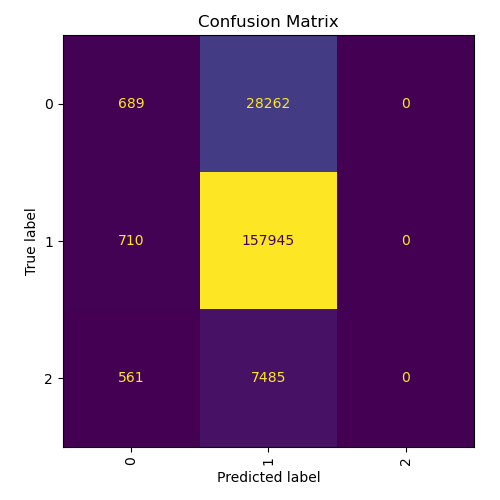

In [28]:
Image(logit_conf_matrix)

 - Random Forest:

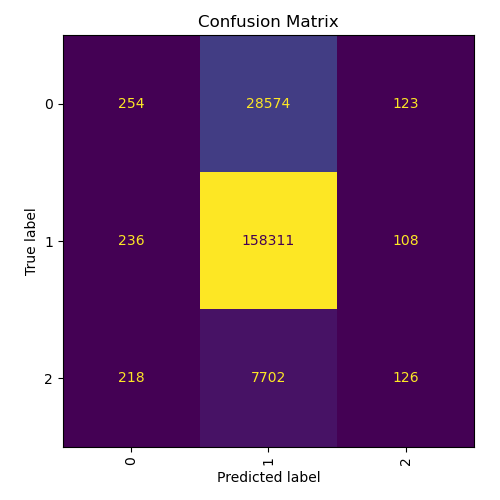

In [29]:
Image(forest_conf_matrix)